# PINN Solver for Dehnen profile

## 1. Introduction
We start from the Dehnen density profile $$\rho(r) = \dfrac{(3-\gamma)M}{4\pi}\dfrac{a}{r^{\gamma}(r+a)^{4-\gamma}} $$
For $\gamma=1$ and $\gamma=2$ we recover the Hernquist and Jaffe profiles, respectively. Note that the parameter $\gamma$ is restriced to the interval $[0, 3)$.

We note that it is convenient to use the expression of Dehnen density profile given in Binnet et ... :

$$\rho(r) = \dfrac{\rho_0}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}} = \dfrac{M}{2\pi a^3}\dfrac{1}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}$$  as $M=2\pi a^3 \rho_0$


For such a potential, the Poisson equation reads:
$$\nabla ^2 \phi = 4\pi G \rho$$

$$ \Leftrightarrow \dfrac{1}{r^2} \dfrac{\partial}{\partial r}\left(r^2 \dfrac{\partial \phi}{\partial r}\right) = 4\pi G \left[\dfrac{M}{2\pi a^3}\dfrac{1}{\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}\right]$$ 

Given that the density-potential pair depends solely on the radial coordinate $r$, the equation reduces to

$$  \dfrac{1}{r^2} \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2GM}{a^3\left(\frac{r}{a}\right)^{\gamma}\left(1+\frac{r}{a}\right)^{4-\gamma}}$$


Setting $s \rightarrow \frac{r}{a}$, we get
$$  \dfrac{1}{a^2 s^2}\dfrac{d}{a ds}\left(a^2 s^2 \dfrac{d \phi}{a ds}\right) = \dfrac{2GM}{a^3 s^{\gamma}(1+s)^{4-\gamma}}$$


Finally, in the case of the Dehnen profile, the Poisson equation can be written such as:

$$ \boxed{\dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) = \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}}}$$

where we have set $\frac{GM}{a}$ to unity and changed back $s$ to $r$.

## 2. Structure of the PINN

Whereas for the Hernquist profile we used the neural network as an approximation of a function $f$ taking as an input only spatial coordinates $r$, we want now the network to take an extra parameter $\gamma$ such as $f(r, \gamma)$.

**Loss function for the Poisson equation**

In our case, we do not consider any data points. Therefore $N_d$ = 0 and $\mathcal{L}_{data}(\theta)=0$. Also we consider for now that $\omega_{\mathcal{F}} = \omega_{\mathcal{B}} = 1$. Finally, we consider in the training a 1-D domain, with $N_c = 1000$ and $N_B = 1$. <font color='red'>Note: Should we consider external boundary condition, and not solely the initial one ?</font>

We note that here, the residual $r_{\theta} (z)$ is as follow :

$$ r_{\theta} (z) = \dfrac{d}{d r}\left(r^2 \dfrac{d \phi}{d r}\right) - \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}}$$

Therefore, we want to minimize the following loss function :

$$ \mathcal{L}(\theta) = \dfrac{1}{N_c}\sum^{N_c}_{i=1} \left\|\dfrac{df}{d r} - \dfrac{2r^{2-\gamma}}{(1+r)^{4-\gamma}} - r_i \right\|^2 + \dfrac{1}{N_B}\sum^{N_B}_{i=1} \left\|\hat{u}(z_0) - u_0\right\|^2$$ 

where we set $f = r^2 \dfrac{d \phi}{d r}$. 

**Boundary conditions:** We create a domain for which $r \in [0.1; 10[$. At $r\approx 0$, the value of $f\approx 0$.

In [1]:
import torch
from torch import nn, optim
import numpy as np
from tqdm.notebook import tqdm, trange

**Implementation of the Neural Network**

In [4]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)])
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

**Implementation of the derivatives for the loss function**

In [5]:
def phi(nn, domain):
    return nn(domain)


def total_derivative(nn, x):
    """ Compute the left-hand side of the Poisson equation in the case of a Dehnen potential:
        d/dr (r^2 dphi/dr) = 2r^(2-\gamma)/(r+1)^{4-\gamma}
    """
    phi_val = phi(nn, x)
    dphi_val = torch.autograd.grad(phi_val, x,
                                   grad_outputs=torch.ones_like(x),
                                   create_graph=True,
                                   retain_graph=True, )[0]
    f = dphi_val * x ** 2
    df = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True,)[0]
    return df

**Implementation of the loss function**

In [6]:
def loss_function(neural_net, domain, gamma, boundaries=(0., 0.)):
    if gamma >= 3:
        raise ValueError("Parameter gamma cannot be greater than 3 (not included)")
    x0, f0 = boundaries
    power1 = 2 - gamma
    power2 = 4 - gamma
    interior_loss = total_derivative(neural_net, domain) - (2 * domain**power1) / (domain + 1) ** power2
    # interior_loss /= -(2 * domain ** power1) / (domain + 1) ** power2 # normalize for convergence
    # interior_loss = 2 * total_derivative(neural_net, domain) * ((domain + 1) ** 3)/domain - 1
    # Boundary contribution
    boundary = torch.Tensor([x0])
    boundary.requires_grad = True
    boundary_loss = phi(neural_net, boundary) - f0

    return interior_loss.pow(2).mean() + boundary_loss[0] ** 2

**Implementation of the training phase**

In [7]:
class TrainingPhase:
    def __init__(self, neural_net, domain, n_epochs, optimizer, _loss_function, boundaries, params=1):
        self.neural_net = neural_net
        self.domain = domain
        self.n_epochs = n_epochs
        self.optimizer = optimizer
        self.loss_function = _loss_function
        self.boundaries = boundaries
        self.x0, self.f0 = boundaries
        self.gamma = params

    def train_model(self):
        opt = self.optimizer(self.neural_net.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                           mode='min',
                                                           factor=0.5,
                                                           patience=1000,
                                                           threshold=0.0001,
                                                           verbose=True)
        loss = self.loss_function

        losses = []
        epochs = []
        for epoch in trange(self.n_epochs, desc="Epoch"):

            opt.zero_grad()
            loss_value = loss(self.neural_net, self.domain, self.gamma, self.boundaries)
            loss_value.backward()
            opt.step()

            losses.append(loss_value.item())
            # if epoch % 100 == 0:
                # print("Époque : ", epoch, "Loss:", loss_value.item())
        return self.neural_net, np.array(epochs), np.array(losses)

    def save_model(self, filename):
        torch.save(self.neural_net, filename)

**Training the Model**

In [8]:
def analytic_prediction(r, _a, _gamma):
    """ Value of the gravitational potential 
        in the case of an Dehnen profile 
    """
    if _gamma == 2:
        return np.log(r/(r + _a))
    else:
        power1 = 2 - _gamma
        return -1/power1 * (1 - (r/(r + _a)) ** power1)

# PARAMETERS
n_epochs = 50_000
a = 1.0
gamma = 0
NUM_HIDDEN_LAYERS = 2
DIM_HIDDEN_LAYERS = 32

pinn = NNApproximator(num_hidden=NUM_HIDDEN_LAYERS, dim_hidden=DIM_HIDDEN_LAYERS, act=nn.Tanh())
print("Training Neural Network :", pinn)

# Domain
s = torch.linspace(0.01, 10, 1000, requires_grad=True)
s = s.reshape(-1, 1)

# Initial conditions
x0 = s.detach().numpy()[0][0] * a
f0 = analytic_prediction(x0, a, gamma)

training = TrainingPhase(neural_net=pinn, domain=s, n_epochs=n_epochs, 
                         optimizer=optim.Adam,_loss_function=loss_function, boundaries=(x0, f0), params=gamma)

net, epochs, losses = training.train_model()
training.save_model(f"resultats/Hernquist_{n_epochs}.pt")


s_plot = torch.linspace(0.1, 10, 1000, requires_grad=False) # Testing domain ?
y_true = analytic_prediction(s_plot.detach().numpy() * a, a, gamma)
y_pred_plot = phi(net, s_plot.reshape(-1, 1)).ravel()
y_pred_train = phi(net, s)

np.save("resultats/analytical_Dehnen.npy", y_true)
np.save("resultats/computed_Dehnen.npy", y_pred_plot.detach().numpy())
np.save("resultats/loss.npy", losses)

Training Neural Network : NNApproximator(
  (layer_in): Linear(in_features=1, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (middle_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (act): Tanh()
)


Epoch:   0%|          | 0/50000 [00:00<?, ?it/s]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

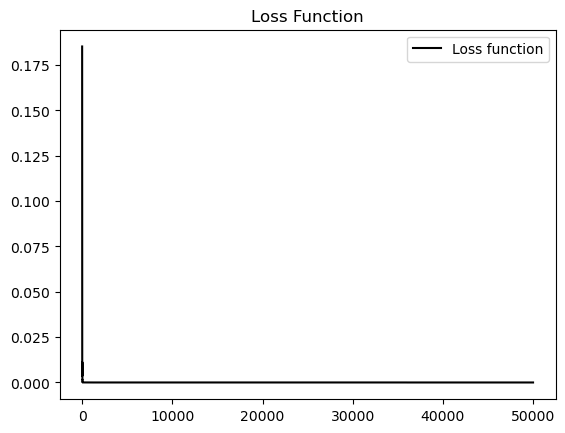

In [10]:
plt.figure()
plt.title("Loss Function")
plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
# plt.yscale("log")
plt.legend()
plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")

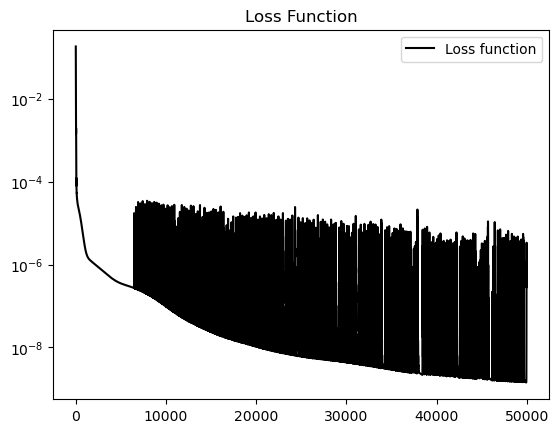

In [11]:
plt.figure()
plt.title("Loss Function")
plt.plot(np.arange(n_epochs), losses, 'k', label="Loss function")
plt.yscale("log")
plt.legend()
plt.savefig(f"resultats/Loss_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")

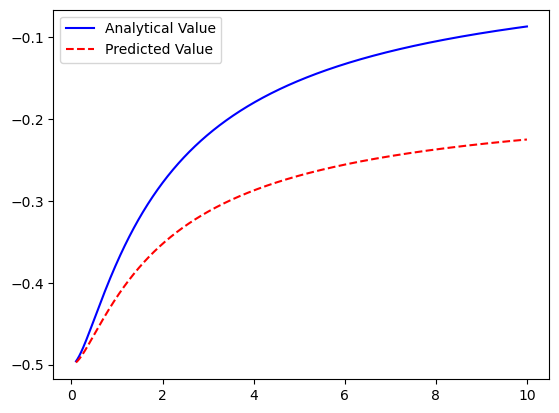

In [12]:
plt.figure()
plt.plot(s_plot.detach().numpy(), y_true, 'b', label="Analytical Value")
plt.plot(s_plot.detach().numpy(), y_pred_plot.detach().numpy(), '--r', label="Predicted Value")
# plt.plot(s.detach().numpy(), y_pred_train.detach().numpy(),'.k', label="Predicted 2")
plt.savefig(f"resultats/Predicttion_{NUM_HIDDEN_LAYERS}x{DIM_HIDDEN_LAYERS}_linear.png")
plt.legend();

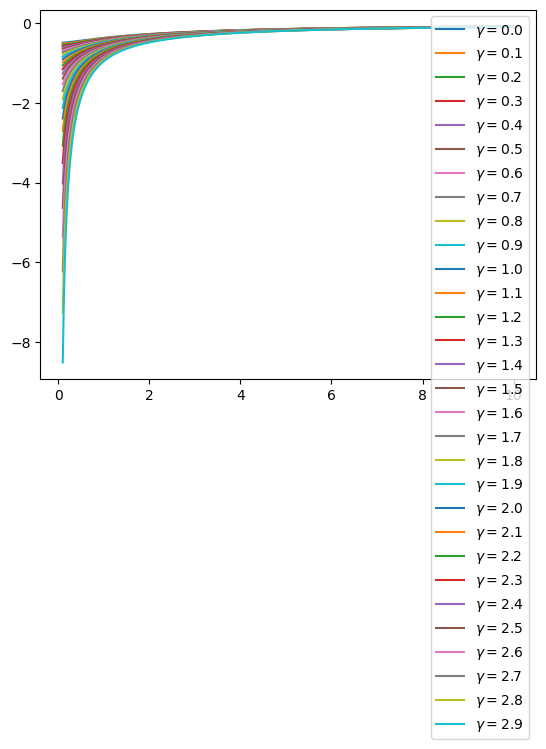

In [26]:
for i  in np.arange(0, 3, 0.1):
    y_true = analytic_prediction(s_plot.detach().numpy() * a, a, i)
    plt.plot(s_plot.detach().numpy() * a, y_true, label=f"$\gamma = {i: .1f}$")
    plt.legend()
plt.savefig("example_profile_gammas.png")

In [2]:
def analytic_prediction(r, _a, _gamma):
    """ Value of the gravitational potential 
        in the case of an Dehnen profile 
    """
    if _gamma == 2:
        return np.log(r/(r + _a))
    else:
        power1 = 2 - _gamma
        return -1/power1 * (1 - (r/(r + _a)) ** power1)

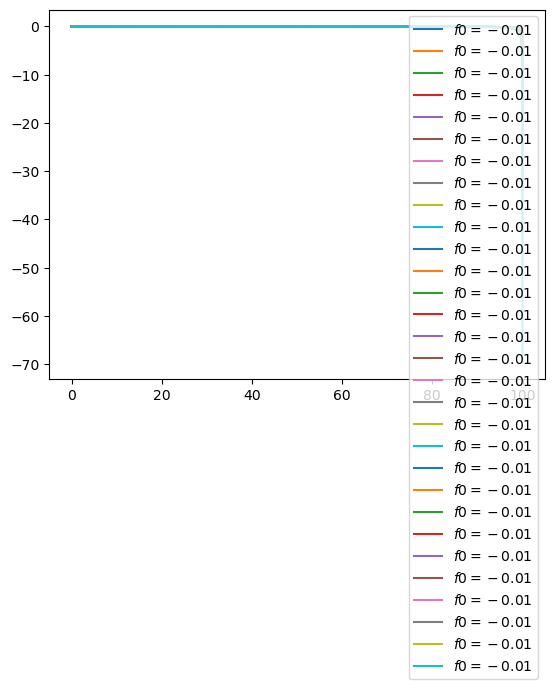

In [62]:
a = 1
x0 = 0.01
domain = np.linspace(x0, 100, 10000)[::-1] * a
for gamma  in np.arange(0, 3, 0.1):
    f0 = analytic_prediction(domain[0], a, gamma)
    y_true = analytic_prediction(domain, a, gamma)
    plt.plot(np.linspace(x0, 100, 10000), y_true, label=f"$f0 = {f0: .2f}$")
    plt.legend()
plt.savefig("inverse_example_profile_gammas.png")

In [39]:
def dehnen(r):
    """ Value of the gravitational potential 
        in the case of an Dehnen profile 
    """
    _gamma = 1
    _a = 1
    if _gamma == 2:
        return np.log(r/(r + _a))
    else:
        power1 = 2 - _gamma
        return -1/power1 * (1 - (r/(r + _a)) ** power1)

In [48]:
def approximation(r, r0, _a):
    fp = -_a/(r * (r+_a))
    fpp = a * (2 * r + a)/(r* (r+a))**2
    return - fp * (r - r0) + (r - r0)**2 * fpp/2

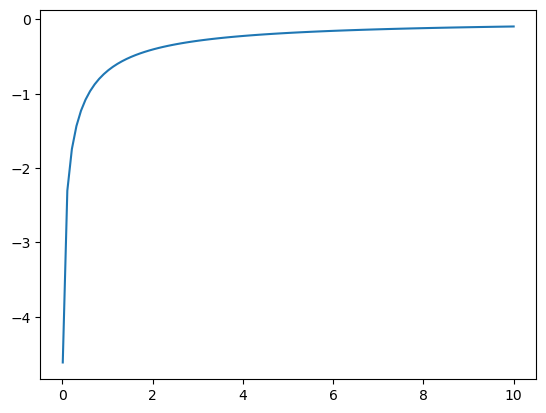

In [56]:
normal_domain = np.linspace(0.01, 10, 100)
# plt.plot(normal_domain, approximation(normal_domain, 10, a)**(-1))
plt.plot(normal_domain, analytic_prediction(normal_domain, a, 2));

In [50]:
print(analytic_prediction(10, a, 2))
print(approximation(domain, 10, a)[-2])

-0.0953101798043249
124941.8492887351


In [33]:
from scipy.misc import derivative
import math

class TaylorSeries():
    def __init__(self, function, order, center=0):
        self.center = center
        self.f = function 
        self.order = order
        self.d_pts = order*2
        self.coefficients = []

        # number of points (order) for scipy.misc.derivative
        if self.d_pts % 2 == 0: # must be odd and greater than derivative order
            self.d_pts += 1

        self.__find_coefficients()

    def __find_coefficients(self):
        for i in range(0, self.order+1):
            self.coefficients.append(round(derivative(self.f, self.center, n=i, order=self.d_pts)/math.factorial(i), 5))
    def print_equation(self):
        eqn_string = ""
        for i in range(self.order + 1):
            if self.coefficients[i] != 0:
                eqn_string += str(self.coefficients[i]) + ("(x-{})^{}".format(self.center, i) if i > 0 else "") + " + "
        eqn_string = eqn_string[:-3] if eqn_string.endswith(" + ") else eqn_string
        print(eqn_string)

    def print_coefficients(self):
        print(self.coefficients)

    def get_coefficients(self):
        """
            Returns the coefficients of the taylor series 
        """
        return self.coefficients

In [40]:
terms = 15
center = 10
precision = 3

ts = TaylorSeries(dehnen, terms, center)
ts.print_coefficients()
ts.print_equation()

/var/folders/t9/37s2572n4y1bwsj0j2rb1zrm0000gn/T/ipykernel_37138/716193019.py:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  self.coefficients.append(round(derivative(self.f, self.center, n=i, order=self.d_pts)/math.factorial(i), 5))


ZeroDivisionError: float division by zero